#### Import packages

In [31]:
using ArchGDAL
using LaTeXStrings
using Plots
using Printf
include("../code/regression.jl")
include("utils_terrain.jl")

bias_variance (generic function with 2 methods)

#### Plot of topographic data

In [4]:
file_path = "SRTM_data_Norway_1.tif"

dataset = ArchGDAL.read(file_path)
band_data = ArchGDAL.read(dataset, 1)
heatmap(band_data, color=:grays, title="SRTM Data Norway", xlabel=L"x_1", ylabel=L"x_2")
savefig("srtm_data_norway.png")


"c:\\Users\\danfy\\Documents\\Projects\\fys-stk4155\\project_1\\calc\\srtm_data_norway.png"

#### Regression of topographic data

In [2]:
function standardize_y(y::Vector{Float64})::Vector{Float64}
  return (y .- mean(y)) ./ std(y)
end

standardize_y (generic function with 1 method)

-- Polynomial regression --
Samples = 100

-- OLS --
Polynomial degree = 2
MSE = 4.73e+04 ± 1.86e+04
R^2 = 3.83e-01 ± 2.95e-01

-- Ridge --
Polynomial degree = 3
λ = 100.0 
MSE = 1.41e+05 ± 5.64e+04
R^2 = -9.36e-01 ± 1.28e+00

-- LASSO --
Polynomial degree = 7
λ = 1000.0 
MSE = 4.63e+04 ± 1.37e+04
R^2 = 3.77e-01 ± 2.29e-01


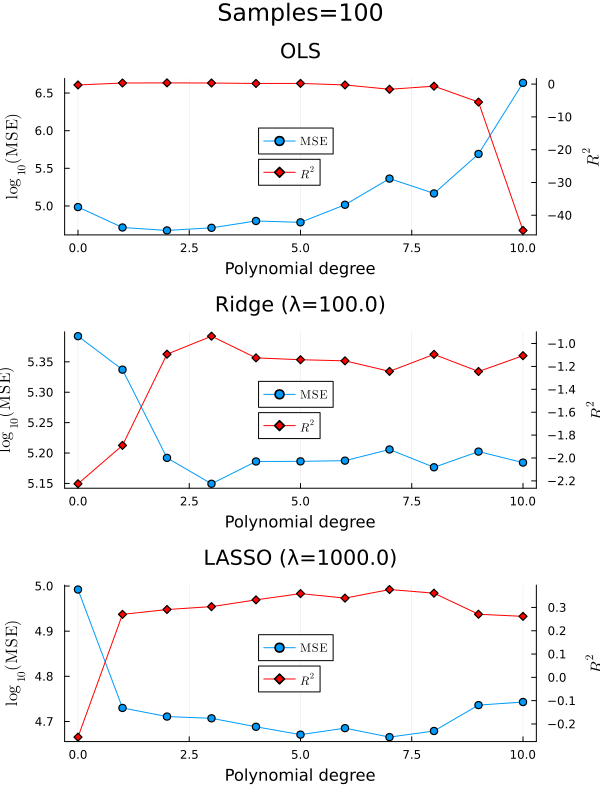

In [23]:
Random.seed!(0)

file_path = "SRTM_data_Norway_1.tif"

fold = 10
samples = 100
degrees = 10

λ_ridge = 100.
λ_lasso = 1000.

x, y = tif_training_data(file_path, samples)
x_scaled = standardize_data(x)

# OLS
mse_ols, r2_ols = cross_validation(x_scaled, y, fold, degrees, ordinary_least_squares, 0.0, false)
mse_ols_mean = mean(mse_ols, dims=2)
mse_ols_std = std(mse_ols, dims=2)
mse_ols_idx = argmin(mse_ols_mean)

r2_ols_mean = mean(r2_ols, dims=2)
r2_ols_std = std(r2_ols, dims=2)

# Ridge
mse_ridge, r2_ridge = cross_validation(x_scaled, y, fold, degrees, ridge_regression, λ_ridge, false)

mse_ridge_mean = mean(mse_ridge, dims=2)
mse_ridge_std = std(mse_ridge, dims=2)
mse_ridge_idx = argmin(mse_ridge_mean)

r2_ridge_mean = mean(r2_ridge, dims=2)
r2_ridge_std = std(r2_ridge, dims=2)

# LASSO
mse_lasso, r2_lasso = cross_validation(x_scaled, y, fold, degrees, lasso_regression, λ_lasso, false)

mse_lasso_mean = mean(mse_lasso, dims=2)
mse_lasso_std = std(mse_lasso, dims=2)
mse_lasso_idx = argmin(mse_lasso_mean)

r2_lasso_mean = mean(r2_lasso, dims=2)
r2_lasso_std = std(r2_lasso, dims=2)

# Result

println("""
-- Polynomial regression --
Samples = $(Int(samples))
""")

println("""
-- OLS --
Polynomial degree = $(mse_ols_idx[1] - 1)
MSE = $(@sprintf("%.2e", mse_ols_mean[mse_ols_idx])) ± $(@sprintf("%.2e", mse_ols_std[mse_ols_idx]))
R^2 = $(@sprintf("%.2e", r2_ols_mean[mse_ols_idx])) ± $(@sprintf("%.2e", r2_ols_std[mse_ols_idx]))
""")

 println("""
-- Ridge --
Polynomial degree = $(mse_ridge_idx[1] - 1)
λ = $(λ_ridge) 
MSE = $(@sprintf("%.2e", mse_ridge_mean[mse_ridge_idx])) ± $(@sprintf("%.2e", mse_ridge_std[mse_ridge_idx]))
R^2 = $(@sprintf("%.2e", r2_ridge_mean[mse_ridge_idx])) ± $(@sprintf("%.2e", r2_ridge_std[mse_ridge_idx]))
""")

println("""
-- LASSO --
Polynomial degree = $(mse_lasso_idx[1] - 1)
λ = $(λ_lasso) 
MSE = $(@sprintf("%.2e", mse_lasso_mean[mse_lasso_idx])) ± $(@sprintf("%.2e", mse_lasso_std[mse_lasso_idx]))
R^2 = $(@sprintf("%.2e", r2_lasso_mean[mse_lasso_idx])) ± $(@sprintf("%.2e", r2_lasso_std[mse_lasso_idx]))""")

degree_range = 0:degrees
p1 = plot(degree_range, log10.(mse_ols_mean), 
  marker=:circle, label=L"\mathrm{MSE}", legend=(0.5,0.6),
  xlabel="Polynomial degree", ylabel=L"\log_{10}(\mathrm{MSE})", 
  title="OLS")
plot!(twinx(), degree_range, r2_ols_mean, 
  marker=:diamond, color=:red, legend=(0.5,0.4),
  label=L"R^2", ylabel=L"R^2"
)

p2 = plot(degree_range, log10.(mse_ridge_mean), 
  marker=:circle, label=L"\mathrm{MSE}", legend=(0.5,0.6),
  xlabel="Polynomial degree", ylabel=L"\log_{10}(\mathrm{MSE})", 
  title="Ridge (λ=$(λ_ridge))")
plot!(twinx(), degree_range, r2_ridge_mean, 
  marker=:diamond, color=:red, legend=(0.5,0.4),
  label=L"R^2", ylabel=L"R^2"
)

p3 = plot(degree_range, log10.(mse_lasso_mean), 
  marker=:circle, label=L"\mathrm{MSE}", legend=(0.5,0.6),
  xlabel="Polynomial degree", ylabel=L"\log_{10}(\mathrm{MSE})", 
  title="LASSO (λ=$(λ_lasso))")
plot!(twinx(), degree_range, r2_lasso_mean, 
  marker=:diamond, color=:red, legend=(0.5,0.4),
  label=L"R^2", ylabel=L"R^2"
)

plot(p1, p2, p3, layout=(3,1), size=(600, 800), 
  plot_title="Samples=$(Int(samples))")


In [25]:
savefig("ols_ridge_lasso_terrain_cross_validation_mse_r2.svg")

"c:\\Users\\danfy\\Documents\\Projects\\fys-stk4155\\project_1\\calc\\ols_ridge_lasso_terrain_cross_validation_mse_r2.svg"

##### Bootstrap resampling

In [ ]:
Random.seed!(0)

file_path = "SRTM_data_Norway_1.tif"

trials = 100
train_ratio = 0.8
samples = 10000
degrees = 10
noise = 0.1

λ_ridge = 100.
λ_lasso = 1.

x, y = tif_training_data(file_path, samples)
if noise > 0.0
  y += noise * randn(samples)
end
x_scaled = standardize_data(x)

# OLS
mse_ols, r2_ols = bootstrap(x_scaled, y, trials, train_ratio, degrees, ordinary_least_squares, 0.0, false)
mse_ols_mean = mean(mse_ols, dims=2)
mse_ols_std = std(mse_ols, dims=2)
mse_ols_idx = argmin(mse_ols_mean)

r2_ols_mean = mean(r2_ols, dims=2)
r2_ols_std = std(r2_ols, dims=2)

# Ridge
mse_ridge, r2_ridge = bootstrap(x_scaled, y, trials, train_ratio, degrees, ridge_regression, λ_ridge, false)

mse_ridge_mean = mean(mse_ridge, dims=2)
mse_ridge_std = std(mse_ridge, dims=2)
mse_ridge_idx = argmin(mse_ridge_mean)

r2_ridge_mean = mean(r2_ridge, dims=2)
r2_ridge_std = std(r2_ridge, dims=2)

# LASSO
mse_lasso, r2_lasso = bootstrap(x_scaled, y, trials, train_ratio, degrees, lasso_regression, λ_lasso, false)

mse_lasso_mean = mean(mse_lasso, dims=2)
mse_lasso_std = std(mse_lasso, dims=2)
mse_lasso_idx = argmin(mse_lasso_mean)

r2_lasso_mean = mean(r2_lasso, dims=2)
r2_lasso_std = std(r2_lasso, dims=2)

# Result

println("""
-- Polynomial regression --
Samples = $(Int(samples^2))
""")

println("""
-- OLS --
Polynomial degree = $(mse_ols_idx[1] - 1)
MSE = $(@sprintf("%.2e", mse_ols_mean[mse_ols_idx])) ± $(@sprintf("%.2e", mse_ols_std[mse_ols_idx]))
R^2 = $(@sprintf("%.2e", r2_ols_mean[mse_ols_idx])) ± $(@sprintf("%.2e", r2_ols_std[mse_ols_idx]))
""")

 println("""
-- Ridge --
Polynomial degree = $(mse_ridge_idx[1] - 1)
λ = $(λ_ridge) 
MSE = $(@sprintf("%.2e", mse_ridge_mean[mse_ridge_idx])) ± $(@sprintf("%.2e", mse_ridge_std[mse_ridge_idx]))
R^2 = $(@sprintf("%.2e", r2_ridge_mean[mse_ridge_idx])) ± $(@sprintf("%.2e", r2_ridge_std[mse_ridge_idx]))
""")

println("""
-- LASSO --
Polynomial degree = $(mse_lasso_idx[1] - 1)
λ = $(λ_lasso) 
MSE = $(@sprintf("%.2e", mse_lasso_mean[mse_lasso_idx])) ± $(@sprintf("%.2e", mse_lasso_std[mse_lasso_idx]))
R^2 = $(@sprintf("%.2e", r2_lasso_mean[mse_lasso_idx])) ± $(@sprintf("%.2e", r2_lasso_std[mse_lasso_idx]))""")

degree_range = 0:degrees
p1 = plot(degree_range, mse_ols_mean, 
  marker=:circle, label=L"\mathrm{MSE}", legend=(0.5,0.6),
  xlabel="Polynomial degree", ylabel=L"\mathrm{MSE}", 
  title="OLS")
plot!(twinx(), degree_range, r2_ols_mean, 
  marker=:diamond, color=:red, legend=(0.5,0.4),
  label=L"R^2", ylabel=L"R^2"
)

p2 = plot(degree_range, mse_ridge_mean, 
  marker=:circle, label=L"\mathrm{MSE}", legend=(0.5,0.6),
  xlabel="Polynomial degree", ylabel=L"\mathrm{MSE}", 
  title="Ridge (λ=$(λ_ridge))")
plot!(twinx(), degree_range, r2_ridge_mean, 
  marker=:diamond, color=:red, legend=(0.5,0.4),
  label=L"R^2", ylabel=L"R^2"
)

p3 = plot(degree_range, mse_lasso_mean, 
  marker=:circle, label=L"\mathrm{MSE}", legend=(0.5,0.6),
  xlabel="Polynomial degree", ylabel=L"\mathrm{MSE}", 
  title="LASSO (λ=$(λ_lasso))")
plot!(twinx(), degree_range, r2_lasso_mean, 
  marker=:diamond, color=:red, legend=(0.5,0.4),
  label=L"R^2", ylabel=L"R^2"
)

plot(p1, p2, p3, layout=(3,1), size=(600, 800), 
  plot_title="Samples=$(Int(samples))")


#### Bias-variance tradeoff

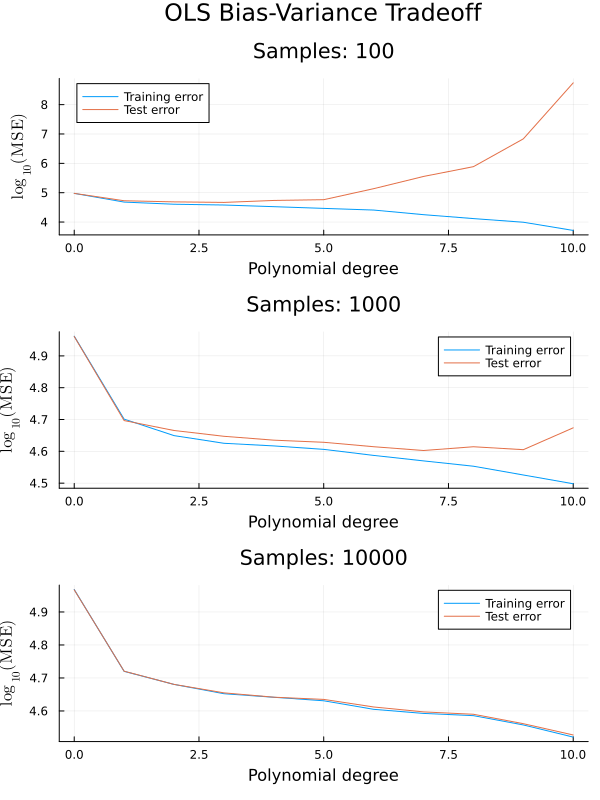

In [37]:
Random.seed!(0)
file_path = "SRTM_data_Norway_1.tif"

trials = 100
train_ratio = 0.8
samples = [100, 1000, 10000]
degrees = 10

degrees_range = 0:degrees

plots = []

for s in samples
  x, y = tif_training_data(file_path, s)
  x_scaled = standardize_data(x)

  test_error, train_error = bias_variance(x_scaled, y, trials, train_ratio, degrees, ordinary_least_squares)
  plot_ = plot(degrees_range, log10.(train_error), 
    label="Training error", xlabel="Polynomial degree", 
    ylabel=L"\log_{10}(\mathrm{MSE})", 
    title="Samples: $(Int(s))")
  plot!(degrees_range, log10.(test_error), label="Test error")
  push!(plots, plot_)
end

plot(plots..., layout=(3,1), plot_title="OLS Bias-Variance Tradeoff", size=(600, 800))

In [39]:
savefig("ols_terrain_bootstrap_bias_variance.svg")

"c:\\Users\\danfy\\Documents\\Projects\\fys-stk4155\\project_1\\calc\\ols_terrain_bootstrap_bias_variance.svg"